<a href="https://colab.research.google.com/github/argalusmp/CH2-PS_Recommendation-System/blob/main/Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Collab](https://colab.research.google.com/drive/1d9l2-NXW5traKPQ0j-l4eZ2vSI0mEVvV)

# Import

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder


# Load Dataset

In [ ]:
# Load Event dataset
event_data = pd.read_csv("./events_dataset.csv",usecols=['Event_id','Category','Location','Qualifications'])
event_df = pd.DataFrame(event_data,)

# Load User dataset
user_data = pd.read_csv("./users_data.csv",usecols=['Volunteer Name','Skills','Location','Type of Organization','Interest'])
# user_data = pd.read_csv("./test.csv",usecols=['Volunteer Name','Skills','Location','Type of Organization','Interest'])
user_df = pd.DataFrame(user_data)

# G Variabel

In [ ]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 20000

# Split Dataset

In [ ]:
# Split event and user data into training and testing sets
event_train, event_test = train_test_split(event_df, test_size=0.2, random_state=42)
user_train, user_test = train_test_split(user_df, test_size=0.2, random_state=42)
y_train, y_test = train_test_split(user_df['Interest'], test_size=0.2, random_state=42)


# Tokenizer

In [ ]:
# Tokenizer Train and Test Qualifications
tokenizer_qualification = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_qualification.fit_on_texts(event_train['Qualifications'])

qualification_seq = tokenizer_qualification.texts_to_sequences(event_train['Qualifications'])
qualification_pad = pad_sequences(qualification_seq, maxlen=max_length, padding=padding_type, truncating= trunc_type)

qualification_seq_test = tokenizer_qualification.texts_to_sequences(event_test['Qualifications'])
qualification_pad_test = pad_sequences(qualification_seq_test, maxlen=max_length, padding=padding_type, truncating= trunc_type)


# Tokenizer Train and Test Skill
tokenizer_skill = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_skill.fit_on_texts(user_train['Skills'])

skill_seq = tokenizer_skill.texts_to_sequences(user_train['Skills'])
skill_pad = pad_sequences(skill_seq, maxlen=max_length, padding=padding_type, truncating= trunc_type)

skill_seq_test = tokenizer_skill.texts_to_sequences(user_test['Skills'])
skill_pad_test = pad_sequences(skill_seq_test, maxlen=max_length, padding=padding_type, truncating= trunc_type)

In [ ]:
word_index = tokenizer_qualification.word_index
for word, index in word_index.items():
    print(f'"{word}":{index},')



In [ ]:
import json

In [ ]:
y = json.dumps(word_index)
y

In [ ]:
with open('data.json', 'w') as f:
    json.dump(word_index, f )

# One Hot Encoding

In [ ]:
# One hot encoding Event
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
event_cat_loc_org_encoded_train = encoder.fit_transform(event_train[['Category', 'Location']])
event_cat_loc_org_encoded_test = encoder.transform(event_test[['Category', 'Location']])

# One hot encoding user
user_loc_org_encoded_train = encoder.fit_transform(user_train[['Location', 'Type of Organization']])
user_loc_org_encoded_test = encoder.transform(user_test[['Location', 'Type of Organization']])

# Bulid Model Keras

In [ ]:
# Build user model
user_NN = tf.keras.models.Sequential([
    Embedding(input_dim=vocab_size, output_dim=32, input_length=max_length),
    tf.keras.layers.LSTM(32, return_sequences=True),
    Flatten(),
    Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    Dense(64, name='user_embedding')  # output layer for user model

])

# Build event model
event_NN = tf.keras.models.Sequential([
    Embedding(input_dim=vocab_size, output_dim=32, input_length=max_length),
    tf.keras.layers.LSTM(32, return_sequences=True),
    Flatten(),
    Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    Dense(64, name='event_embedding')  # output layer for event model
])



# Set Input for `fit()`

In [ ]:
# Inputs for user and event
input_user_skills = Input(shape=(max_length,), name='input_user_skills')
input_user_loc_org = Input(shape=(user_loc_org_encoded_train.shape[1],), name='input_user_loc_org')
input_event_qualifications = Input(shape=(max_length,), name='input_event_qualifications')
input_event_cat_loc_org = Input(shape=(event_cat_loc_org_encoded_train.shape[1],), name='input_event_cat_loc_org')

In [ ]:
# Call user and event models
vu_skills = user_NN(input_user_skills)
vu_loc_org = Dense(128, activation='relu')(input_user_loc_org)
vu = Concatenate()([vu_skills, vu_loc_org])

vm_qualifications = event_NN(input_event_qualifications)
vm_cat_loc_org = Dense(128, activation='relu')(input_event_cat_loc_org)
vm = Concatenate()([vm_qualifications, vm_cat_loc_org])

combined_vu_vm = Concatenate()([vu, vm])

# Specify the inputs and outputs of the model
# model = tf.keras.Model([input_user_skills, input_user_loc_org, input_event_qualifications, input_event_cat_loc_org], [vu, vm])

# model with combined
model = Model([input_user_skills, input_user_loc_org, input_event_qualifications, input_event_cat_loc_org],combined_vu_vm)

Callbacks|

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the method that checks the accuracy at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('loss') < 0.00005 :
            print("\nReached loss 5e-5 so stop the epoch for training!")
            self.model.stop_training = True

callback = myCallback()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Menambahkan early stopping
early_stopping = EarlyStopping(monitor='loss', patience=6)

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_user_skills (InputLa  [(None, 120)]                0         []                            
 yer)                                                                                             
                                                                                                  
 input_user_loc_org (InputL  [(None, 97)]                 0         []                            
 ayer)                                                                                            
                                                                                                  
 input_event_qualifications  [(None, 120)]                0         []                            
  (InputLayer)                                                                                

In [ ]:
# Define inputs and outputs for training
train_inputs = [skill_pad, user_loc_org_encoded_train, qualification_pad, event_cat_loc_org_encoded_train]

In [ ]:
history = model.fit(train_inputs, y_train, epochs=100, callbacks=[callback,early_stopping])

Epoch 1/100
70/70 [==============================] - 14s 80ms/step - loss: 11.8400 - root_mean_squared_error: 3.4409
Epoch 2/100
70/70 [==============================] - 3s 37ms/step - loss: 10.0339 - root_mean_squared_error: 3.1676
Epoch 3/100
70/70 [==============================] - 4s 52ms/step - loss: 8.9953 - root_mean_squared_error: 2.9992
Epoch 4/100
70/70 [==============================] - 2s 31ms/step - loss: 8.1157 - root_mean_squared_error: 2.8488
Epoch 5/100
70/70 [==============================] - 1s 18ms/step - loss: 7.3267 - root_mean_squared_error: 2.7068
Epoch 6/100
70/70 [==============================] - 1s 21ms/step - loss: 6.6266 - root_mean_squared_error: 2.5742
Epoch 7/100
70/70 [==============================] - 1s 21ms/step - loss: 5.9828 - root_mean_squared_error: 2.4460
Epoch 8/100
70/70 [==============================] - 1s 14ms/step - loss: 5.3990 - root_mean_squared_error: 2.3236
Epoch 9/100
70/70 [==============================] - 1s 14ms/step - loss: 4.8

In [ ]:
test_inputs = [skill_pad_test, user_loc_org_encoded_test, qualification_pad_test, event_cat_loc_org_encoded_test]
model.evaluate(test_inputs, y_test)

18/18 [==============================] - 1s 11ms/step - loss: 0.6971 - root_mean_squared_error: 0.8349


[0.6970611810684204, 0.8349019289016724]

# Prediction


In [ ]:
## using the user in the test set
user_index = 0
user_input = [
    skill_pad_test[user_index][None, ...],
    user_loc_org_encoded_test[user_index][None, ...],
    qualification_pad_test[user_index][None, ...],
    event_cat_loc_org_encoded_test[user_index][None, ...],
]

Using weighting for event category and type of organization user

In [ ]:
# Buat prediksi dengan model Anda
user_predictions = model.predict(user_input)

# Ubah prediksi menjadi DataFrame
predictions_df = pd.DataFrame(user_predictions.flatten(), columns=['Interest_Score'])

# Gabungkan prediksi dengan data acara
results_df = pd.concat([event_test.reset_index(drop=True), predictions_df], axis=1)

# add nama pengguna dan 'Type of Organization' ke DataFrame hasil
results_df['User_Name'] = user_test.iloc[user_index]['Volunteer Name']
results_df['User_Organization_Type'] = user_test.iloc[user_index]['Type of Organization']
# kolom baru 'Interest_Score_Adjusted' yang memberikan bobot lebih tinggi
# untuk acara yang 'Category'-nya cocok dengan 'Type of Organization' pengguna
results_df['Interest_Score_Adjusted'] = np.where(results_df['Category'] == results_df['User_Organization_Type'],
                                                 results_df['Interest_Score'] * 1.002,
                                                 results_df['Interest_Score'])

# Urutkan acara berdasarkan 'Interest_Score_Adjusted' dalam urutan menurun
results_df = results_df.sort_values(by='Interest_Score_Adjusted', ascending=False)

# Tampilkan 5 rekomendasi tertinggi
top_5_recommendations = results_df
top_5_recommendations.head(10)


1/1 [==============================] - 0s 24ms/step


,Event_id,Category,Location,Qualifications,Interest_Score,User_Name,User_Organization_Type,Interest_Score_Adjusted
263,E803,Environmental,Yogyakarta,"Environmental education, Conservation, Wildlif...",4.081981,Ethan Walker,Environmental,4.090145
260,E1118,Environmental,Bali,Wildlife rehabilitation,4.068672,Ethan Walker,Environmental,4.076809
282,E366,Youth Development,Jakarta,"Leadership development, Event coordination, Pu...",4.076404,Ethan Walker,Environmental,4.076404
323,E1296,Healthcare,Tangerang,"Healthcare, Special needs support, Research",4.075939,Ethan Walker,Environmental,4.075939
265,E582,IT,Indonesia,"Graphic design, Lab assistance, Web development",4.074848,Ethan Walker,Environmental,4.074848
289,E150,Youth Development,Yogyakarta,"Content creation, Youth mentoring",4.072135,Ethan Walker,Environmental,4.072135
273,E943,Environmental,Yogyakarta,"Environmental education, Conservation, Wildlif...",4.063133,Ethan Walker,Environmental,4.071259
286,E1191,Environmental,Bali,Wildlife rehabilitation,4.062576,Ethan Walker,Environmental,4.070701
342,E747,IT,Tangerang,"Lab technician, Lab assistance, Photography",4.070486,Ethan Walker,Environmental,4.070486
381,E1028,Environmental,Bali,Wildlife rehabilitation,4.062274,Ethan Walker,Environmental,4.070398


In [ ]:
user_test.columns
user_test.head(5)

,Volunteer Name,Skills,Location,Type of Organization,Interest
2078,Ethan Walker,"Environmental activism, Conservation",Serang,Environmental,5
2770,James Cooper,"Veterinary assistance, Animal rescue",Lubuklinggau,Healthcare,3
1465,Amelia Adams,"Nursing, Geriatric care",Bengkulu,Youth Development,3
2089,Liam Thompson,"Teaching, English language tutoring",Palembang,Social,5
2118,Emily Davis,"Animal shelter volunteering, Pet adoption support",Binjai,Pet and Animal Service,3


In [ ]:
name_at_index_one = user_test.loc[user_test.index[0], 'Volunteer Name']
print("Name at index one:", name_at_index_one)

Name at index one: Ethan Walker


Directly predict user_test

In [ ]:
user_predictions = model.predict(user_input)

# Change prediksi menjadi DataFrame
predictions_df = pd.DataFrame(user_predictions.flatten(), columns=['Interest_Score'])

# Gabungkan prediksi dengan data event
results_df = pd.concat([event_test.reset_index(drop=True), predictions_df], axis=1)

# sort event berdasarkan 'Interest_Score'
results_df = results_df.sort_values(by='Interest_Score', ascending=False)

# Tampilkan 5 rekomendasi tertinggi
top_5_recommendations = results_df.head(5)
top_5_recommendations


1/1 [==============================] - 0s 23ms/step


,Event_id,Category,Location,Qualifications,Interest_Score
263,E803,Environmental,Yogyakarta,"Environmental education, Conservation, Wildlif...",4.081981
282,E366,Youth Development,Jakarta,"Leadership development, Event coordination, Pu...",4.076404
323,E1296,Healthcare,Tangerang,"Healthcare, Special needs support, Research",4.075939
265,E582,IT,Indonesia,"Graphic design, Lab assistance, Web development",4.074848
289,E150,Youth Development,Yogyakarta,"Content creation, Youth mentoring",4.072135


In [ ]:
# Example new user
new_user_data = {
    'Volunteer Name' : 'Anto Sutirto',
    'Skills': 'Python, Data Analysis',
    'Location': 'Jakarta',
    'Type of Organization': 'IT',
}
new_userData = pd.DataFrame([new_user_data])

# Pra-pemrosesan data user baru
new_user_skills_seq = tokenizer_skill.texts_to_sequences(new_userData['Skills'])
new_user_skills_pad = pad_sequences(new_user_skills_seq, maxlen=max_length, padding=padding_type, truncating= trunc_type)

new_user_loc_org_encoded = encoder.transform(new_userData[['Location','Type of Organization']])

# memberikan input untuk 'Qualifications' dan 'Category' dan 'Location' dari event.
# menggunakan rata-rata atau median dari data training untuk ini.
average_qualifications_pad = np.mean(qualification_pad, axis=0)[None, ...]
average_event_cat_loc_org_encoded = np.mean(event_cat_loc_org_encoded_train, axis=0)[None, ...]

# Membuat input untuk model
new_user_input = [
    new_user_skills_pad,
    new_user_loc_org_encoded,
    average_qualifications_pad,
    average_event_cat_loc_org_encoded,
]

In [ ]:
# Membuat prediksi dengan model
new_user_predictions = model.predict(new_user_input)

# Mengubah prediksi menjadi DataFrame
predictions_df = pd.DataFrame(new_user_predictions.flatten(), columns=['Interest_Score'])

# Menggabungkan prediksi dengan data event
results_df = pd.concat([event_test.reset_index(drop=True), predictions_df], axis=1)

# Menambahkan 'Type of Organization' user ke DataFrame hasil
results_df['User_Organization_Type'] = new_userData.iloc[0]['Type of Organization']

# Membuat kolom baru 'Interest_Score_Adjusted' yang memberikan bobot lebih tinggi
# untuk event yang 'Category'-nya cocok dengan 'Type of Organization' user
results_df['Interest_Score_Adjusted'] = np.where(results_df['Category'] == results_df['User_Organization_Type'],
                                                 results_df['Interest_Score'] * 1.1,
                                                 results_df['Interest_Score'])

# Mengurutkan event berdasarkan 'Interest_Score_Adjusted' dalam urutan menurun
results_df = results_df.sort_values(by='Interest_Score_Adjusted', ascending=False)

# Menampilkan 5 rekomendasi tertinggi
top_recommendations = results_df.head(5)
top_recommendations


1/1 [==============================] - 0s 23ms/step


,Event_id,Category,Location,Qualifications,Interest_Score,User_Organization_Type,Interest_Score_Adjusted
192,E451,IT,Yogyakarta,"Customer service, Emergency response, Administ...",4.018081,IT,4.419889
248,E507,IT,Bandung,"Graphic design, Computer programming, Data ana...",4.015686,IT,4.417254
241,E421,IT,Yogyakarta,"Database management, Web development, Data ana...",4.013658,IT,4.415024
246,E472,IT,Indonesia,Customer service,4.013035,IT,4.414339
222,E568,IT,Yogyakarta,"Visual communication, Computer literacy, Compu...",4.012087,IT,4.413296


In [ ]:
user_predictions = model.predict(new_user_input)

# Change prediksi menjadi DataFrame
predictions_df = pd.DataFrame(user_predictions.flatten(), columns=['Interest_Score'])

# Gabungkan prediksi dengan data event
results_df = pd.concat([event_test.reset_index(drop=True), predictions_df], axis=1)

# sort event berdasarkan 'Interest_Score'
results_df = results_df.sort_values(by='Interest_Score', ascending=False)

# Tampilkan 5 rekomendasi tertinggi
top_5_recommendations = results_df.head()
top_5_recommendations

1/1 [==============================] - 0s 23ms/step


,Event_id,Category,Location,Qualifications,Interest_Score
192,E451,IT,Yogyakarta,"Customer service, Emergency response, Administ...",4.018081
248,E507,IT,Bandung,"Graphic design, Computer programming, Data ana...",4.015686
241,E421,IT,Yogyakarta,"Database management, Web development, Data ana...",4.013658
221,E2051,Event Organizer,Jakarta,"Visual communication, Communication, Graphic d...",4.013505
254,E1534,Healthcare,"Maluku, Banda Neira",Healthcare,4.013428


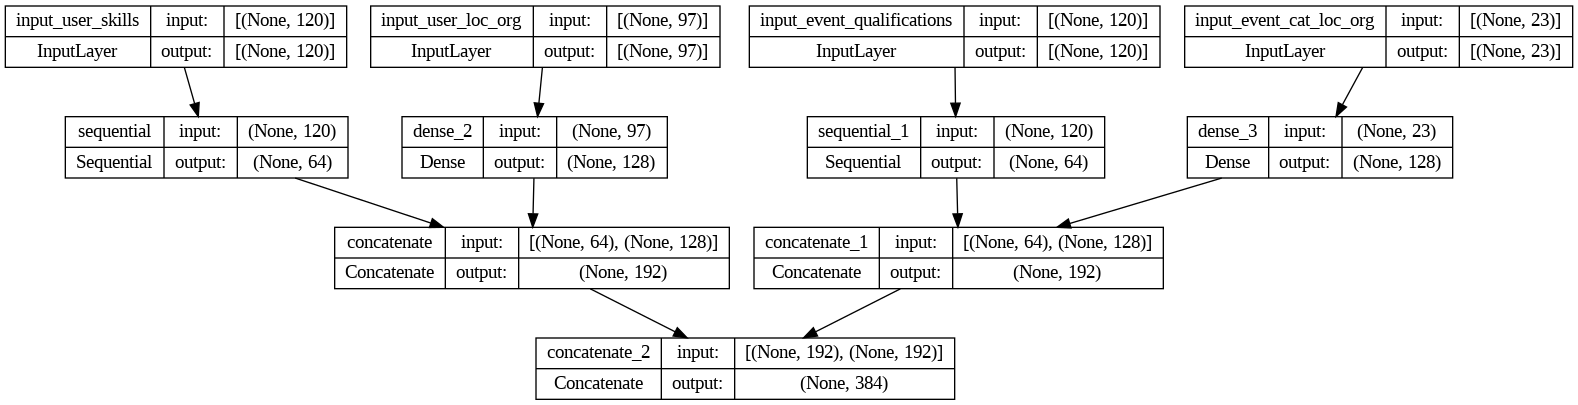

In [ ]:
from tensorflow.keras.utils import plot_model

# Membuat visualisasi model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


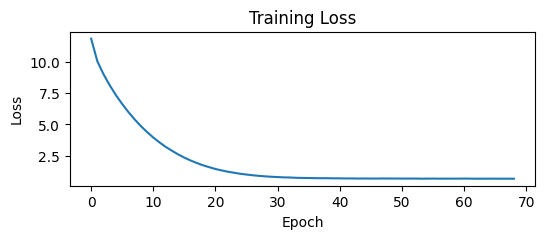

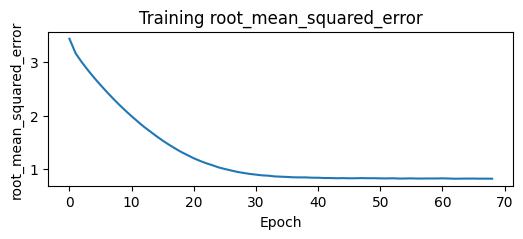

In [ ]:
import matplotlib.pyplot as plt

# Membuat plot loss pelatihan
plt.figure(figsize=(6, 2))
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Membuat plot akurasi pelatihan
plt.figure(figsize=(6, 2))
plt.plot(history.history['root_mean_squared_error'])
plt.title('Training root_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('root_mean_squared_error')
plt.show()

# TF JS

In [ ]:
saved_model_path = "./my_model.h5"


model.save(saved_model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 37.7 MB/s eta 0:00:00


In [ ]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

2023-12-20 15:40:08.777655: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 15:40:08.777706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 15:40:08.778905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 15:40:09.985637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
!zip output_model.zip *.bin model.json my_model.h5

  adding: group1-shard1of2.bin (deflated 8%)
  adding: group1-shard2of2.bin (deflated 7%)
  adding: model.json (deflated 87%)
  adding: my_model.h5 (deflated 40%)


In [ ]:
# model.save('./saved_model')
#!pip install tensorflowjs
# !tensorflowjs_converter --input_format =tf_saved_model \
#                       --output_node_names='concatenate_2' \
#                       /saved_model \
#                        /output


# Convert To TF Lite

In [ ]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('my_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Joblib for encoder export

In [ ]:
pip install joblib

In [ ]:
import joblib

# Simpan encoder yang telah di-fit
joblib.dump(encoder, 'encoder.joblib')

['encoder.joblib']

# Saving category and location event


In [ ]:
# Simpan nilai rata-rata sebagai file numpy
np.save('average_qualifications_pad.npy', average_qualifications_pad)
np.save('average_event_cat_loc_org_encoded.npy', average_event_cat_loc_org_encoded)
